# Define Success Metrics - all companies
Define what constitutes "success" for a startup based on available data. In this notebook, success was definied based on a composite score with status and age used for score calculation. This step is crucial as it establishes our target variable for prediction.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the companies dataset
print("Loading companies dataset...")
companies_df = pd.read_csv('all_final_companies.csv', low_memory=False)
print(f"Dataset loaded with {companies_df.shape[0]} rows and {companies_df.shape[1]} columns")

Loading companies dataset...
Dataset loaded with 196509 rows and 6 columns


In [2]:
# Examine the status distribution to understand potential success indicators
status_counts = companies_df['status'].value_counts()
print("\nCompany Status Distribution:")
print(status_counts)
print(f"\nPercentage of companies by status:")
print(status_counts / status_counts.sum() * 100)

# Visualize the status distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='status', data=companies_df, order=companies_df['status'].value_counts().index)
plt.title('Distribution of Company Status')
plt.tight_layout()
plt.savefig('status_distribution.png')
plt.show
plt.close()


Company Status Distribution:
status
operating    183441
acquired       9391
closed         2543
ipo            1134
Name: count, dtype: int64

Percentage of companies by status:
status
operating   93.35
acquired     4.78
closed       1.29
ipo          0.58
Name: count, dtype: float64



Funding Statistics (USD):
count      196509.00
mean      1992018.89
std      16629982.32
min             0.00
25%             0.00
50%             0.00
75%             0.00
max     687250706.52
Name: funding_total_usd, dtype: float64

Funding Quartiles (USD):
0.25          0.00
0.50          0.00
0.75          0.00
0.90     750000.00
0.95    6000000.00
0.99   45000000.00
Name: funding_total_usd, dtype: float64


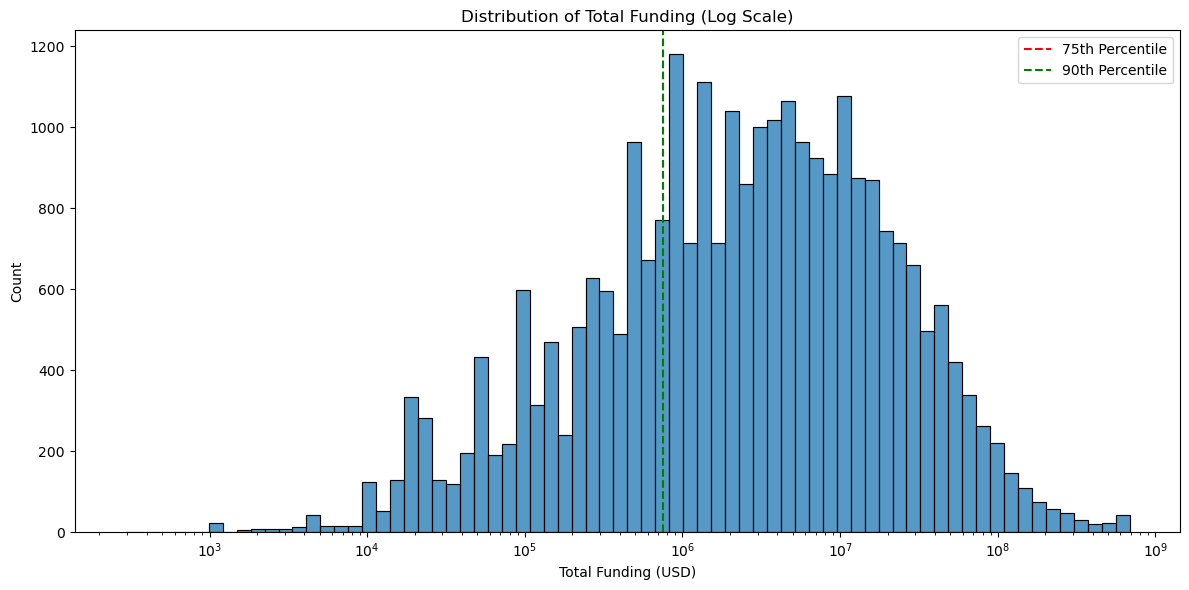

In [3]:
# Examine funding distribution for companies with funding data
funding_stats = companies_df['funding_total_usd'].describe()
print("\nFunding Statistics (USD):")
print(funding_stats)

# Calculate funding quartiles for companies with funding data
companies_with_funding = companies_df[companies_df['funding_total_usd'].notna()]
funding_quartiles = companies_with_funding['funding_total_usd'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nFunding Quartiles (USD):")
print(funding_quartiles)

# Visualize funding distribution (log scale due to high skew)
plt.figure(figsize=(12, 6))
sns.histplot(companies_with_funding['funding_total_usd'], log_scale=True)
plt.title('Distribution of Total Funding (Log Scale)')
plt.xlabel('Total Funding (USD)')
plt.axvline(funding_quartiles[0.75], color='r', linestyle='--', label='75th Percentile')
plt.axvline(funding_quartiles[0.9], color='g', linestyle='--', label='90th Percentile')
plt.legend()
plt.tight_layout()
plt.savefig('funding_distribution.png')
plt.show()


Company Age Statistics (years):
count   196509.00
mean         7.37
std          6.91
min          0.00
25%          6.00
50%          6.00
75%          6.00
max        114.00
Name: age, dtype: float64

Age Quartiles (years):
0.25    6.00
0.50    6.00
0.75    6.00
0.80    7.00
0.90   12.00
Name: age, dtype: float64


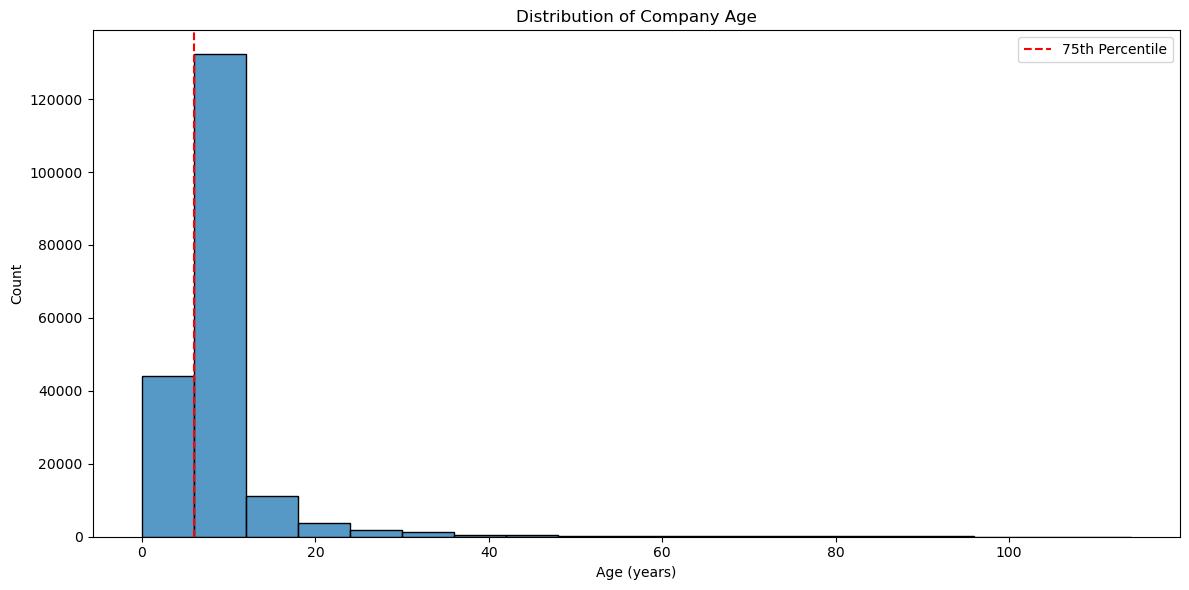

In [4]:
# Print age statistics
age_stats = companies_df['age'].describe()
print("\nCompany Age Statistics (years):")
print(age_stats)

# Calculate age quartiles
companies_with_age = companies_df[companies_df['age'].notna()]
age_quartiles = companies_with_age['age'].quantile([0.25, 0.5, 0.75, 0.8, 0.9])
print("\nAge Quartiles (years):")
print(age_quartiles)

# Visualize age distribution
plt.figure(figsize=(12, 6))
sns.histplot(companies_with_age['age'])
plt.title('Distribution of Company Age')
plt.xlabel('Age (years)')
plt.axvline(age_quartiles[0.75], color='r', linestyle='--', label='75th Percentile')
plt.legend()
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.show()

In [5]:
# Define success metrics based on our analysis

# 1. Status-based success (acquired or IPO)
companies_df['success_status'] = companies_df['status'].apply(
    lambda x: 1 if x in ['acquired', 'ipo'] else 0
)

# Print status-based success distribution
print("\nStatus-based Success Distribution:")
status_success_counts = companies_df['success_status'].value_counts()
print(status_success_counts)
print(f"Percentage successful: {status_success_counts[1] / status_success_counts.sum() * 100:.2f}%")


Status-based Success Distribution:
success_status
0    185984
1     10525
Name: count, dtype: int64
Percentage successful: 5.36%



Composite Success Score Distribution:
success_score
0    151421
1     34563
3      6107
4      4418
Name: count, dtype: int64


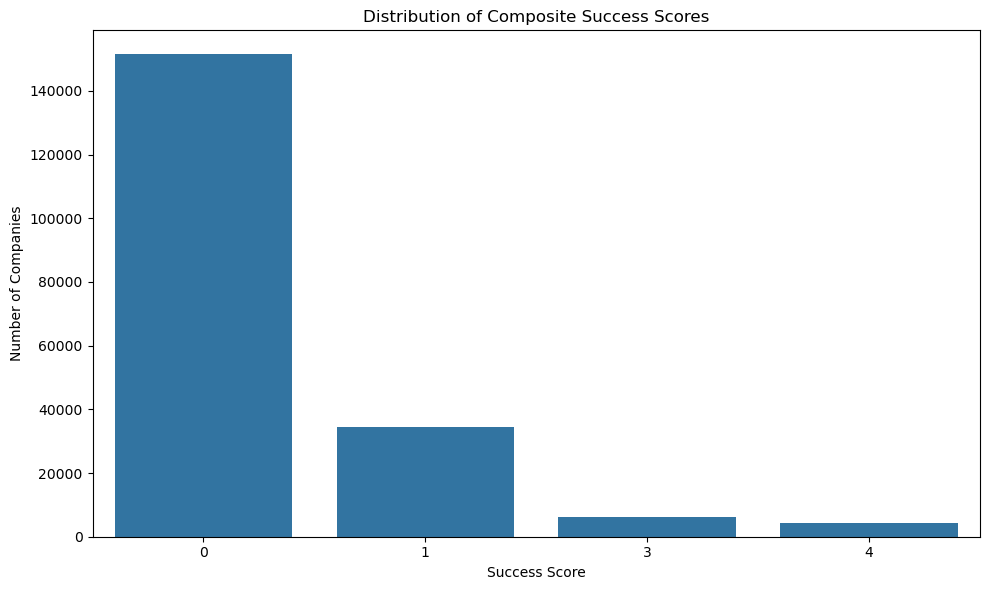

In [6]:
# Create a composite success metric combining status and age factors

# Define a function to assign a composite success score
def assign_composite_success(row):
    score = 0

    # Status-based component (highest weight)
    if row['status'] in ['acquired', 'ipo']:
        score += 3

    # Age-based component, only if status is not 'closed'
    if row['status'] != 'closed' and pd.notna(row['age']):
        if row['age'] >= age_quartiles[0.8]:  # Top 20%
            score += 1

    return score

# Apply the composite scoring function
companies_df['success_score'] = companies_df.apply(assign_composite_success, axis=1)

# Print composite score distribution
print("\nComposite Success Score Distribution:")
score_counts = companies_df['success_score'].value_counts().sort_index()
print(score_counts)

# Visualize the score distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='success_score', data=companies_df, order=sorted(companies_df['success_score'].unique()))
plt.title('Distribution of Composite Success Scores')
plt.xlabel('Success Score')
plt.ylabel('Number of Companies')
plt.tight_layout()
plt.savefig('success_score_distribution.png')
plt.show()


In [7]:
# Binary success label (score of 1 or higher considered successful)
success_threshold = 1
companies_df['success_binary'] = (companies_df['success_score'] >= success_threshold).astype(int)

# Print binary success distribution
print("\nBinary Success Label Distribution based on the Composite Score:")
binary_counts = companies_df['success_binary'].value_counts()
print(binary_counts)
print(f"Percentage successful: {binary_counts[1] / binary_counts.sum() * 100:.2f}%")


Binary Success Label Distribution based on the Composite Score:
success_binary
0    151421
1     45088
Name: count, dtype: int64
Percentage successful: 22.94%


In [8]:
# Save the dataset with success labels
output_file = 'all_companies_with_success_labels.csv'
print(f"\nSaving dataset with success labels to {output_file}...")
companies_df.to_csv(output_file, index=False)
print(f"Saved {companies_df.shape[0]} rows with success metrics")


Saving dataset with success labels to all_companies_with_success_labels.csv...
Saved 196509 rows with success metrics


In [11]:
#create final dataset for modeling without the 'age' column
# Load your datasets
usa_final_companies = pd.read_csv('all_final_companies.csv')
usa_companies_with_success_labels = pd.read_csv('all_companies_with_success_labels.csv')

# Drop the first column (assuming it's an index or unwanted)
usa_final_companies = usa_final_companies.iloc[:, 1:]

# Add the 'success_binary' column from the other file
usa_final_companies['success_binary'] = usa_companies_with_success_labels['success_binary']

# Drop the 'age' column if it exists
if 'age' in usa_final_companies.columns:
    usa_final_companies = usa_final_companies.drop(columns=['age'])

# Save the result to a new CSV file
usa_final_companies.to_csv('all_final_companies_with_success_labels.csv', index=False)


In [10]:
usa_final_companies.head()

,funding_rounds,funding_total_usd,milestones,relationships,success_binary
0,3.00,39750000.00,5.00,17.00,1
1,0.00,0.00,0.00,6.00,1
2,0.00,0.00,4.00,12.00,1
3,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0
